In [66]:
! wget "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"

import zipfile

with zipfile.ZipFile("./ml-latest-small.zip", "r") as zip_ref:
  zip_ref.extractall('.')

! rm -rf "ml-latest-small.zip"

--2022-11-04 19:27:46--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  --.-KB/s    in 0.1s    

2022-11-04 19:27:46 (8.49 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [141]:
def show_progress_bar(current_i, total_length, size):
  e = ((current_i+1)/total_length) 
  print('\r', f'{((current_i+1)/total_length)*100 :.2f}%', '['+''.join(['=']*math.ceil(e*size)) + '>' + ''.join([' ']*math.floor((1-e)*size))+']',end='')

In [142]:
# monitoring memory usage
import tracemalloc
tracemalloc.start()
memory_usage = []
memory_usage.append(tracemalloc.get_traced_memory()[0])

In [143]:
import pandas as pd

movies = pd.read_csv('ml-latest-small/movies.csv'  , quotechar='"', skipinitialspace=True)
ratings = pd.read_csv('ml-latest-small/ratings.csv', quotechar='"', skipinitialspace=True)
tags = pd.read_csv('ml-latest-small/tags.csv'      , quotechar='"', skipinitialspace=True)

# monitoring memory usage
memory_usage.append(tracemalloc.get_traced_memory()[0])

<function matplotlib.pyplot.show(*args, **kw)>

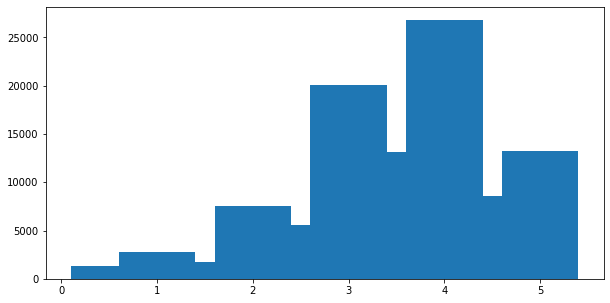

In [144]:
# rating destribution 
from matplotlib import pyplot as plt

data = ratings[['rating', 'movieId']].groupby(['rating'], as_index=False)['movieId'].count()
plt.figure(figsize=(10,5))
plt.bar(data['rating'], data['movieId'])
plt.show

In [145]:
# Normalizing the ratings
ratings['rating'] = ratings['rating'] / 5

# Putting tags and genres to lower case to avoid duplicates
tags['tag'] = tags['tag'].str.lower()
movies['genres'] = movies['genres'].str.lower()

In [146]:
display(ratings.head(10))

,userId,movieId,rating,timestamp
0,1,1,0.8,964982703
1,1,3,0.8,964981247
2,1,6,0.8,964982224
3,1,47,1.0,964983815
4,1,50,1.0,964982931
5,1,70,0.6,964982400
6,1,101,1.0,964980868
7,1,110,0.8,964982176
8,1,151,1.0,964984041
9,1,157,1.0,964984100


In [147]:
# Evalution set
import random

k = 25 # number of users to include in the evaluation set
s = 0.1 # the fraction of ratings to add to the evaluation set from each user
rating_threshold = 0.5 # the rating threshold from where we start considering a rated movie as relevant

evaluation_set = {}

e_users = random.choices(ratings[ratings['rating'] >= rating_threshold]['userId'].tolist(), k=k)
for e_u in e_users:
  evaluation_set[e_u] = ratings[ratings['userId'] == e_u][ratings['rating'] >= rating_threshold].sample(frac=s)
  ratings = ratings.drop(evaluation_set[e_u].index.tolist())

# monitoring memory usage
memory_usage.append(tracemalloc.get_traced_memory()[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


In [148]:
evaluation_set[random.choice(e_users)].head(10)

,userId,movieId,rating,timestamp
21126,140,350,0.6,949667416
21190,140,1017,0.8,1021899101
21410,140,3751,0.6,977403302
21659,140,34334,0.5,1124825511
21098,140,110,0.8,942903980
21561,140,5867,1.0,1117729634
21599,140,6753,0.7,1067986859
21101,140,151,0.8,949667175
21498,140,4901,0.6,1030558967
21414,140,3827,0.6,993208295


In [149]:
# Computing  idf for each tag 
import math
features_hash = {} # using features hash instead of strings
tags_occ = [] # keeping the number of occurrences of each tag over all movies 

idf = pd.DataFrame({})

# Computing the hash of each feature and the number of it occurences
for x in tags['tag']:
  if x not in features_hash.keys():
    features_hash[x] = hash(x) % (2*len(tags['tag']))
    tags_occ.append(len(tags[tags['tag'] == x]['movieId'].unique()))

idf['tag'] = features_hash.values()
idf['occ'] = tags_occ

# IDF calculation
c_idf = []
for v in features_hash.values():
  c_idf.append(math.log(len(movies['movieId'].unique())/idf[idf['tag'] == v].reset_index().loc[0, 'occ'], 10))

idf['idf'] = c_idf
display(idf.head(5))

# monitoring memory usage
memory_usage.append(tracemalloc.get_traced_memory()[0])

,tag,occ,idf
0,5337,22,2.646225
1,4715,3,3.511527
2,5003,6,3.210497
3,1929,1,3.988648
4,5073,1,3.988648


In [150]:
# Computation of feature frequency
freq_f_m = {} # To store the frequency of each feature per movie

for i, x in enumerate(movies['movieId'].unique()):
  t = tags[tags['movieId'] == x].groupby(['tag'], as_index=False)['movieId'].count() # Calculating the number of time a tag appearch for each movie
  t.rename(columns={'movieId': 'tagCount', 'tag': 'feature'}, inplace=True, errors='raise')
  
  tmp = t['feature'].tolist()
  hashed_tags = []
  for v in tmp:
    hashed_tags.append(features_hash[v])

  t['feature'] = hashed_tags
  t['tf'] = t['tagCount'] / t['tagCount'].max() # computing TF
  freq_f_m[x] = t

  show_progress_bar(i, len(movies['movieId'].unique()), 40)

display(freq_f_m[1].head(10))

# monitoring memory usage
memory_usage.append(tracemalloc.get_traced_memory()[0])

 100.00% [========================================>]

,feature,tagCount,tf
0,2720,1,0.5
1,1432,2,1.0


In [151]:
# computing tf-idf of tags
for i, movie in enumerate(freq_f_m.keys()):
  movie_features = freq_f_m[movie]
  tmp = []
  for y in movie_features['feature'].tolist():
    tmp.append(movie_features[movie_features['feature'] == y].reset_index().loc[0, 'tf'] * idf[idf['tag'] == y].reset_index().loc[0,'idf'])
  movie_features['tf-idf'] = tmp
  show_progress_bar(i,len(freq_f_m), 40)

# monitoring memory usage
memory_usage.append(tracemalloc.get_traced_memory()[0])

 100.00% [========================================>]

In [152]:
display(freq_f_m[1])

,feature,tagCount,tf,tf-idf
0,2720,1,0.5,1.644839
1,1432,2,1.0,3.386588


In [153]:
# Definition of aggregation function to aggregate user profiles

def weighted_average(u_movies):
  profile_tags = []

  # concatinating all weighted item profiles related to the user
  for i, m in u_movies.iterrows():
    temp = freq_f_m[m['movieId']][['feature', 'tf-idf']]
    temp['agg'] = temp['tf-idf'] * m['rating']
    profile_tags.append(temp)
  profile_tags = pd.concat(profile_tags)
  profile_tags = profile_tags.drop(columns=['tf-idf'])
  profile_tags = profile_tags.groupby(['feature'], as_index=False)['agg'].sum() # aggregating the weighted item profiles grouping by the feautre hash
  profile_tags['agg'] = profile_tags['agg'] / u_movies['rating'].sum() # averaging the weighted item profiles

  return profile_tags

# Only the min of each tf-idf is kept for every item profile to compute the user profile
def aggregation_by_min(u_movies):
  profile_tags = pd.concat([freq_f_m[m][['feature', 'tf-idf']]for m in u_movies['movieId'].tolist()])
  profile_tags = profile_tags.groupby(['feature'], as_index=False)['tf-idf'].min()
  profile_tags.rename(columns={'tf-idf':'agg'}, inplace=True, errors='raise')

  return profile_tags

In [154]:
# adding movie genre as features
movie_genres = pd.DataFrame({})
for x in movies['movieId'].tolist():
  genres = movies.iloc[movies.loc[movies['movieId'] == x].index[0]]['genres'].split('|')
  mov = [x] * len(genres)

  movie_genres = pd.concat([movie_genres, pd.DataFrame({'movieId': mov, 'genre': genres, 'occ' : [1] *len(genres)})])

# monitoring memory usage
memory_usage.append(tracemalloc.get_traced_memory()[0])

In [155]:
genre_occ = movie_genres.groupby(['genre'], as_index=False)['occ'].count()
display(genre_occ.head(10))

# monitoring memory usage
memory_usage.append(tracemalloc.get_traced_memory()[0])

,genre,occ
0,(no genres listed),34
1,action,1828
2,adventure,1263
3,animation,611
4,children,664
5,comedy,3756
6,crime,1199
7,documentary,440
8,drama,4361
9,fantasy,779


<BarContainer object of 20 artists>

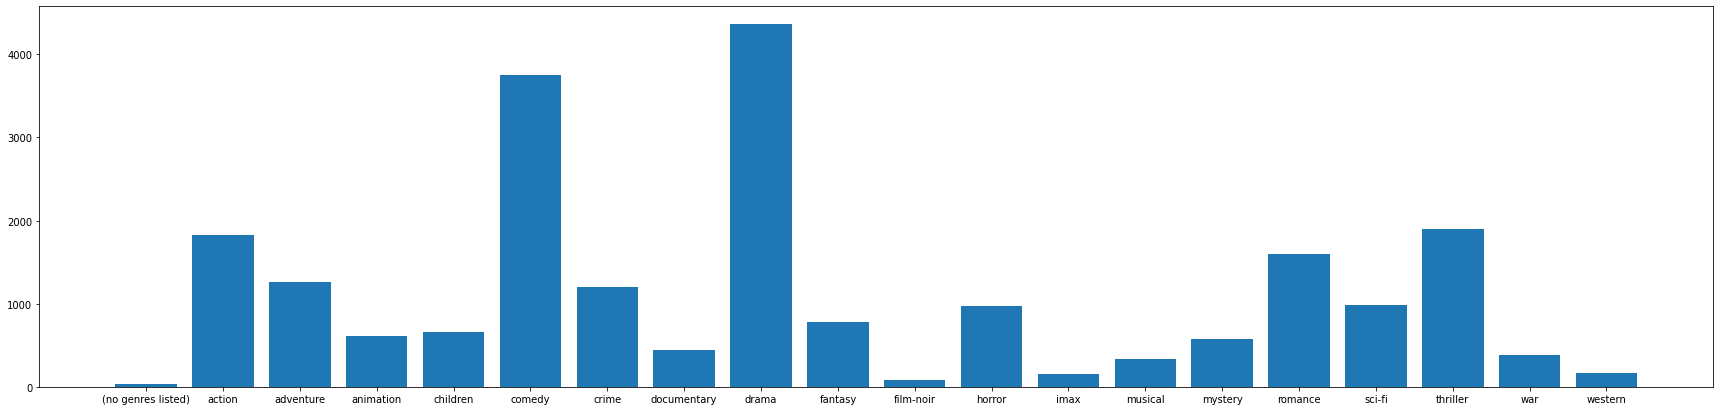

In [156]:
plt.figure(figsize=(30,7))
plt.bar(genre_occ['genre'], genre_occ['occ'])

In [157]:
# Computing the idf for each genre

tmp = []
for x in genre_occ['genre'].tolist():
  tmp.append(math.log(float(len(movies))/float(genre_occ.iloc[genre_occ.loc[genre_occ['genre'] == x].index[0]]['occ'])))
genre_occ['idf'] = tmp
for x in genre_occ['genre'].tolist():
  features_hash[x] = hash(x) % (2*len(tags['tag']))
genre_occ['genre'] = [hash(x) % (2*len(tags['tag'])) for x in genre_occ['genre'].tolist()]

# monitoring memory usage
memory_usage.append(tracemalloc.get_traced_memory()[0])

In [158]:
display(genre_occ.head(10))

,genre,occ,idf
0,2324,34,5.657841
1,2326,1828,1.673224
2,4234,1263,2.042957
3,1492,611,2.769105
4,5114,664,2.685920
5,1555,3756,0.953092
6,5564,1199,2.094959
7,3987,440,3.097427
8,276,4361,0.803745
9,5682,779,2.526191


In [159]:
# adding the tf-idf of genre to itme profiles

for i, m in enumerate(list(freq_f_m.keys())):
  t = freq_f_m[m]
  gs = movies.iloc[movies.loc[movies['movieId'] == m].index[0]]['genres'].split('|')

  df_g = pd.DataFrame({})
  df_g['feature'] = [features_hash[x] for x in gs]
  df_g['tagCount'] = [1] * len(gs)
  df_g['tf'] = [1/t['tagCount'].max()] * len(gs)

  tmp = []
  for g in gs:
    tmp.append(genre_occ[genre_occ['genre'] == features_hash[g]].reset_index().loc[0, 'idf'] * df_g[df_g['feature'] == features_hash[g]].reset_index().loc[0, 'tf'])
  df_g['tf-idf'] = tmp

  freq_f_m[m] = pd.concat([t, df_g])
  show_progress_bar(i, len(list(freq_f_m.keys())), 40)

# monitoring memory usage
memory_usage.append(tracemalloc.get_traced_memory()[0])

 100.00% [========================================>]

In [160]:
freq_f_m[1]

,feature,tagCount,tf,tf-idf
0,2720,1,0.5,1.644839
1,1432,2,1.0,3.386588
0,4234,1,0.5,1.021478
1,1492,1,0.5,1.384552
2,5114,1,0.5,1.342960
3,1555,1,0.5,0.476546
4,5682,1,0.5,1.263095


In [161]:
# computing the user profile using one of the aggregation function above 

user_profiles = pd.DataFrame({})

userIds = ratings['userId'].unique()
for i, u in enumerate(userIds):
  rating = ratings[ratings['userId'] == u]
  x = weighted_average(rating[['movieId', 'rating']])
  x.loc[:,'userId'] = [u]*len(x)

  user_profiles = pd.concat([x, user_profiles])
  show_progress_bar(i,len(userIds),40)

# monitoring memory usage
memory_usage.append(tracemalloc.get_traced_memory()[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


 100.00% [========================================>]

In [165]:
import numpy as np

# cosine similarity
def cosSim(x, i):
  return np.dot(x, i) / np.linalg.norm(x) * np.linalg.norm(i)

# Jaccard similarity
def jaccardSim(x, i):
  return len(np.intersect1d(x,i)) / len(np.union1d(x, i))

def recommend(uid, k):
  u_profile = user_profiles[user_profiles['userId'] == uid]

  # Adding missing features to the user profiles with score 0
  full_user_profile =[]
  for t in features_hash.values():
    if t in u_profile['feature'].tolist():
      full_user_profile.append(u_profile[u_profile['feature'] == t]['agg'].tolist()[0])
    else:
      full_user_profile.append(0)

  sims = {}

  # removing the already rated movies from set of movies used in the recommendation
  rated_movies = ratings[ratings['userId'] == uid]['movieId'].tolist()
  not_rated_movies = list(set(freq_f_m.keys()) - set(rated_movies))
  for i, m in enumerate(not_rated_movies):
    m_profile = freq_f_m[m]

    # Adding missing features to the item profile with score 0
    full_movie_profile =[]
    for t in features_hash.values():
      if t in m_profile['feature'].tolist():
        full_movie_profile.append(m_profile[m_profile['feature'] == t]['tf-idf'].tolist()[0])
      else:
        full_movie_profile.append(0)
    sims[m] = cosSim(full_user_profile, full_movie_profile)

    #show_progress_bar(i,len(not_rated_movies),40)
  
  df_sims = pd.DataFrame({'movieId': sims.keys(), 'score': sims.values()})
  
  return df_sims.nlargest(k, 'score')['movieId'].tolist() # retreving k movies with largest similarity score 

In [163]:
ms = recommend(1, 30)
# monitoring memory usage
memory_usage.append(tracemalloc.get_traced_memory()[0])

for x in ms:
  print(movies[movies['movieId'] == x].reset_index().loc[0, 'title'])

Up (2009)
The Lego Movie (2014)
Lord of the Rings: The Return of the King, The (2003)
Princess Mononoke (Mononoke-hime) (1997)
Batman v Superman: Dawn of Justice (2016)
Corpse Bride (2005)
Fantastic Four (2005)
Neon Genesis Evangelion: The End of Evangelion (Shin seiki Evangelion Gekijô-ban: Air/Magokoro wo, kimi ni) (1997)
Fantastic Four: Rise of the Silver Surfer (2007)
Suicide Squad (2016)
Beauty and the Beast (1991)
Laputa: Castle in the Sky (Tenkû no shiro Rapyuta) (1986)
Howl's Moving Castle (Hauru no ugoku shiro) (2004)
Cinderella (1950)
Snow White and the Seven Dwarfs (1937)
FLCL (2000)
Terminator Salvation (2009)
It's Such a Beautiful Day (2012)
Incredibles, The (2004)
Shrek (2001)
Watership Down (1978)
Mary and Max (2009)
Lemony Snicket's A Series of Unfortunate Events (2004)
Maze Runner, The (2014)
Shrek 2 (2004)
WALL·E (2008)
Gintama: The Movie (2010)
League of Extraordinary Gentlemen, The (a.k.a. LXG) (2003)
City of God (Cidade de Deus) (2002)
Scott Pilgrim vs. the World (

# Evaluation

[77659480,
 82182446,
 87811624,
 78448314,
 78273274,
 97541315,
 98465307,
 97750789,
 98794721,
 65152099,
 77225861,
 94010718]

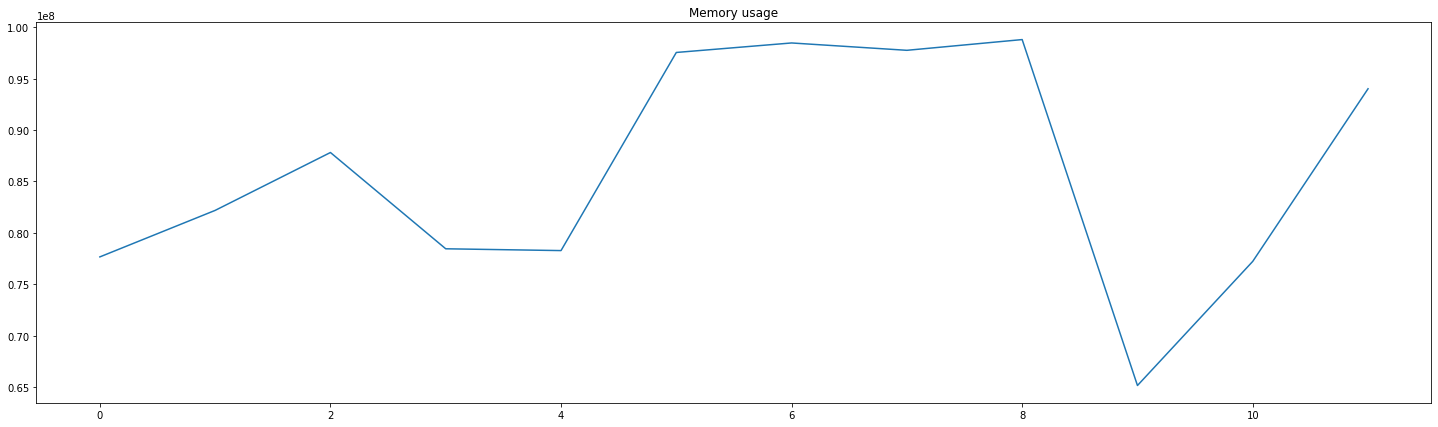

In [170]:
# stopping the library
tracemalloc.stop()

display(memory_usage)

# ploting memory usage over the algorithm
plt.figure(figsize=(25, 7))
plt.plot(memory_usage)
plt.title('Memory usage')
plt.show()

In [171]:

import datetime

def precision(rel, ret):
  return len(np.intersect1d(rel, ret))/len(ret)

def recall(rel, ret):
  return len(np.intersect1d(rel, ret))/len(rel)

exectime = [] # execution time for each user over the evaluation set
prec = [] # precision over the evaluation set
rec = [] # recall over the evaluation set
f1 = [] # F1 score over the evaluation set

prec_g = [] # precision of genres over the evaluation set
rec_g = [] # recall of genres over the evaluation set
f1_g = [] # F1 score of genres over the evaluation set


for i, e_u in enumerate(e_users):

  e_data = evaluation_set[e_u]
  rel_movies = e_data['movieId'].tolist() # relevant movies for current user
  # retreiving relevant genres for current user
  for m in rel_movies: 
    tmp = movies.iloc[movies.loc[movies['movieId'] == m].index[0]]['genres'].split('|')
    rel_genres = [features_hash[g] for g in tmp]

  t1 = datetime.datetime.now().timestamp() # timestamp before execution of recommendation
  reco_movies = recommend(e_u, len(rel_movies))
  t2 = datetime.datetime.now().timestamp() # timestamp after exection of recommendation

  # retreiving recommended genres for current user
  for m in reco_movies:
    tmp = movies.iloc[movies.loc[movies['movieId'] == m].index[0]]['genres'].split('|')
    reco_genres = [features_hash[g] for g in tmp]

  exectime.append(t2-t1) # storing delta time of execution

  # computing precision, recall and f1 score for each user
  prec.append(precision(rel_movies, reco_movies))
  rec.append(recall(rel_movies, reco_movies))

  prec_g.append(precision(rel_genres, reco_genres))
  rec_g.append(recall(rel_genres, reco_genres))
  
  if rec[-1] + prec[-1] > 0:
    f1.append(2 * ((rec[-1] * prec[-1]) / (rec[-1] + prec[-1])))
  else:
    f1.append(0)

  if rec_g[-1] + prec_g[-1] > 0:
    f1_g.append(2 * ((rec_g[-1] * prec_g[-1]) / (rec_g[-1] + prec_g[-1])))
  else:
    f1_g.append(0)
  
  show_progress_bar(i, len(e_users), 40)

 100.00% [========================================>]

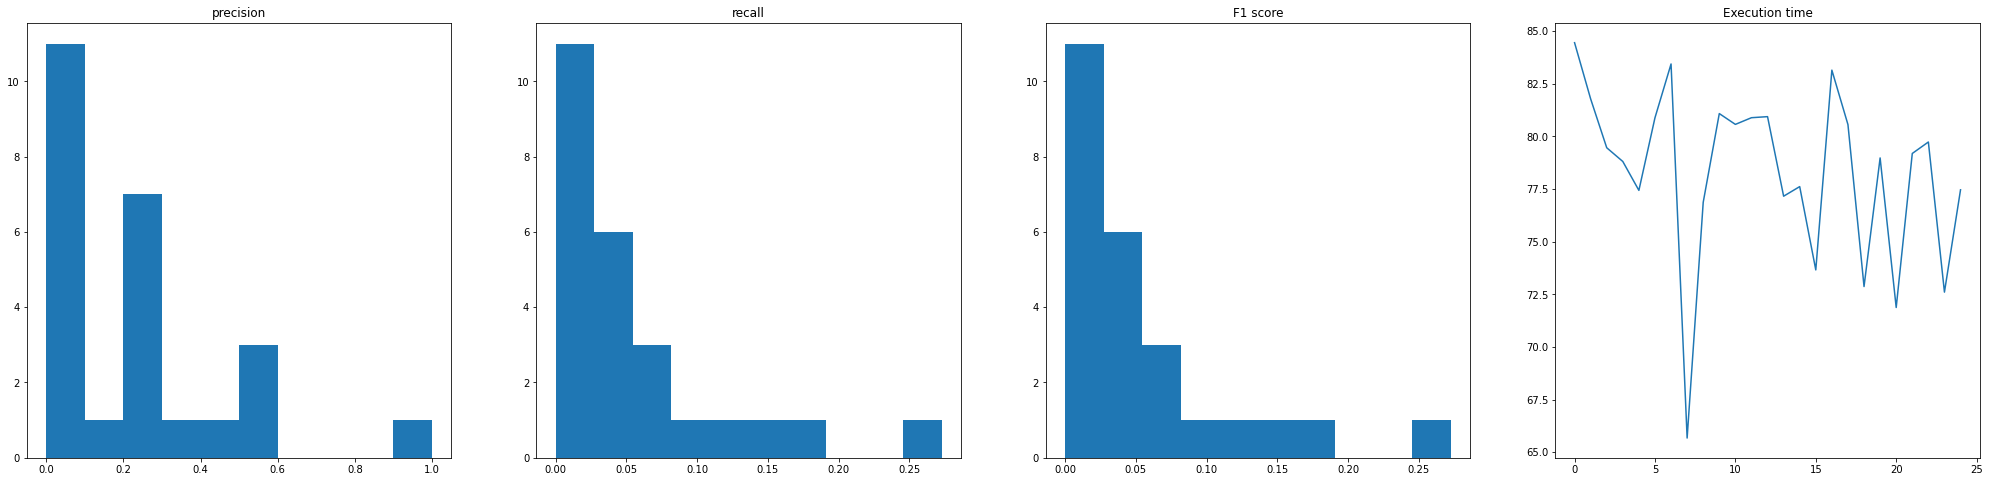

In [176]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(35,8))
ax1.hist(prec_g)
ax1.set_title('precision')
ax2.hist(rec)
ax2.set_title('recall')
ax3.hist(f1)
ax3.set_title('F1 score')
ax4.plot(exectime)
ax4.set_title('Execution time')
fig.show()

In [177]:
print(f'Average precision {np.mean(prec):.4f}')
print(f'Average recall {np.mean(rec):.4f}')
print(f'Average F1 score {np.mean(f1):.4f}')
print(f'Average execution time {np.mean(exectime):.4f}s per recommandation')

Average precision 0.0541
Average recall 0.0541
Average F1 score 0.0541
Average execution time 78.2838s per recommandation


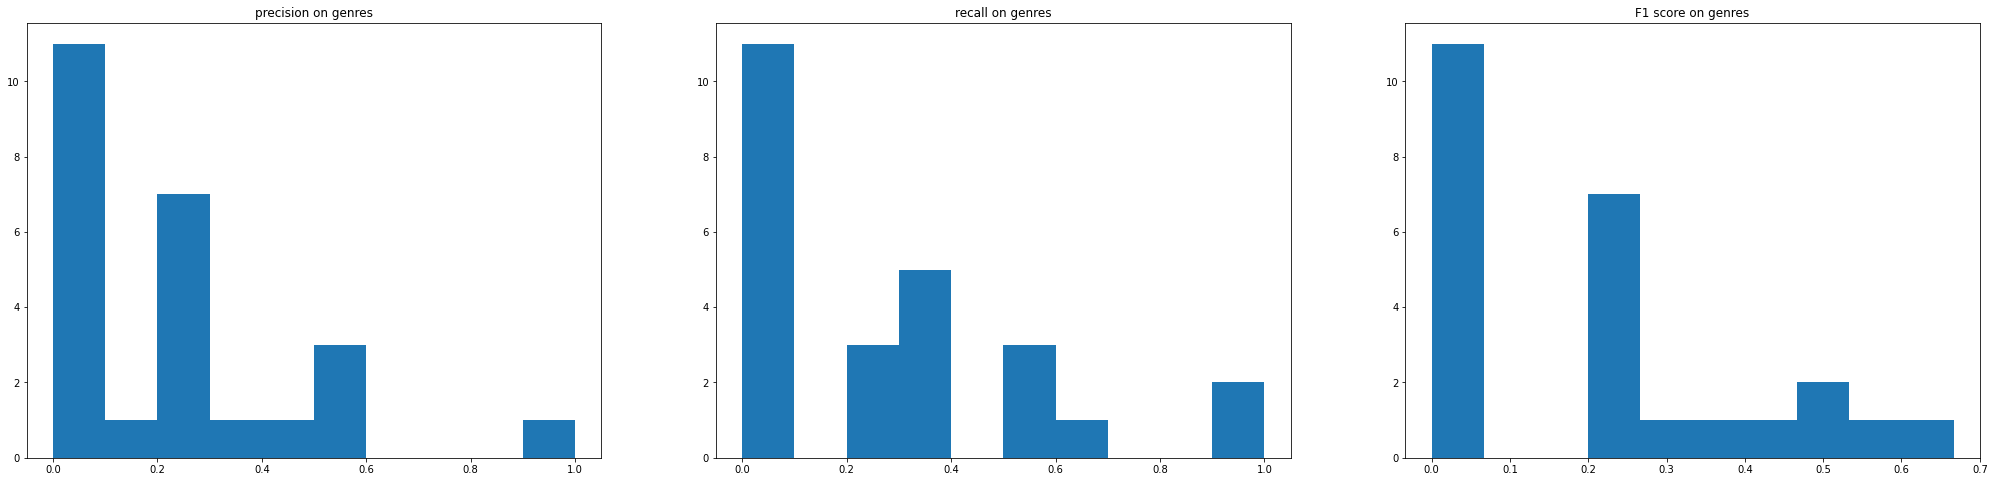

In [178]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(35,8))
ax1.hist(prec_g)
ax1.set_title('precision on genres')
ax2.hist(rec_g)
ax2.set_title('recall on genres')
ax3.hist(f1_g)
ax3.set_title('F1 score on genres')
fig.show()

In [179]:
print(f'Average precision on genres {np.mean(prec_g):.4f}')
print(f'Average recall on genres {np.mean(rec_g):.4f}')
print(f'Average F1 score on genres {np.mean(f1_g):.4f}')

Average precision on gneres 0.1940
Average recall on gneres 0.2613
Average F1 score on gneres 0.1998
